![Demosaicking](https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/0129bbd70539e5c601b76b03e4d3883f67c39e72/Sesiones/Sesion2/Images/poster_sesion2.png)

# 🎨 **Hands-on Sesión 2.4: Convolución y Filtrado de Imágenes** 🖼️

En esta sesión aprenderemos sobre **convolución y filtrado** en imágenes digitales. Exploraremos:

✅ Implementación de la convolución desde cero 🧮
✅ Filtros espaciales comunes (Gaussian, Sobel, Laplacian) 🎭
✅ Generación y análisis de ruido en imágenes 📊
✅ Técnicas de desenfoque (Blur) 🔍
✅ Filtrado inverso para restauración de imágenes ♻️

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity
from scipy import fftpack, signal
import warnings
warnings.filterwarnings('ignore')

## 🔢 **1. Implementación de la Convolución desde Cero**

In [2]:
def convolve(image, kernel):
    """
    Aplica una convolución 2D a una imagen usando un kernel dado.
    """
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]
    pad = (kW - 1) // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    output = np.zeros((iH, iW), dtype="float32")

    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            output[y - pad, x - pad] = (roi * kernel).sum()

    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
    return output

## 🎭 **2. Filtros Gaussianos y Detección de Bordes**

In [3]:
smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
largeBlur = np.ones((21, 21), dtype="float") * (1.0 / (21 * 21))
sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
sobelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobelY = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

kernelBank = {
    "small_blur": smallBlur,
    "large_blur": largeBlur,
    "sharpen": sharpen,
    "laplacian": laplacian,
    "sobel_x": sobelX,
    "sobel_y": sobelY
}

## 🖼️ **3. Cargando Imagen de Entrada**

In [4]:
%%capture
url = "https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/2024/Sesiones/Sesion2/Imagenes/goku1.jpeg"
name = "goku1.jpeg"
!wget -O $name $url

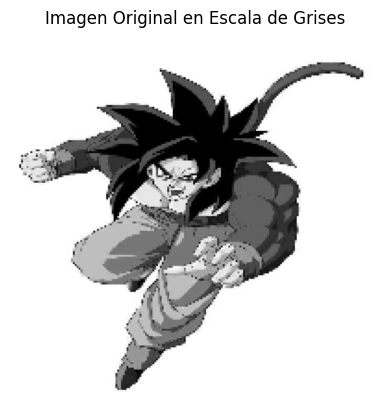

In [5]:
image = cv2.imread("goku1.jpeg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (200, 200))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')
plt.title("Imagen Original en Escala de Grises")
plt.axis('off')
plt.show()

## 🔍 **4. Aplicando Diferentes Filtros**

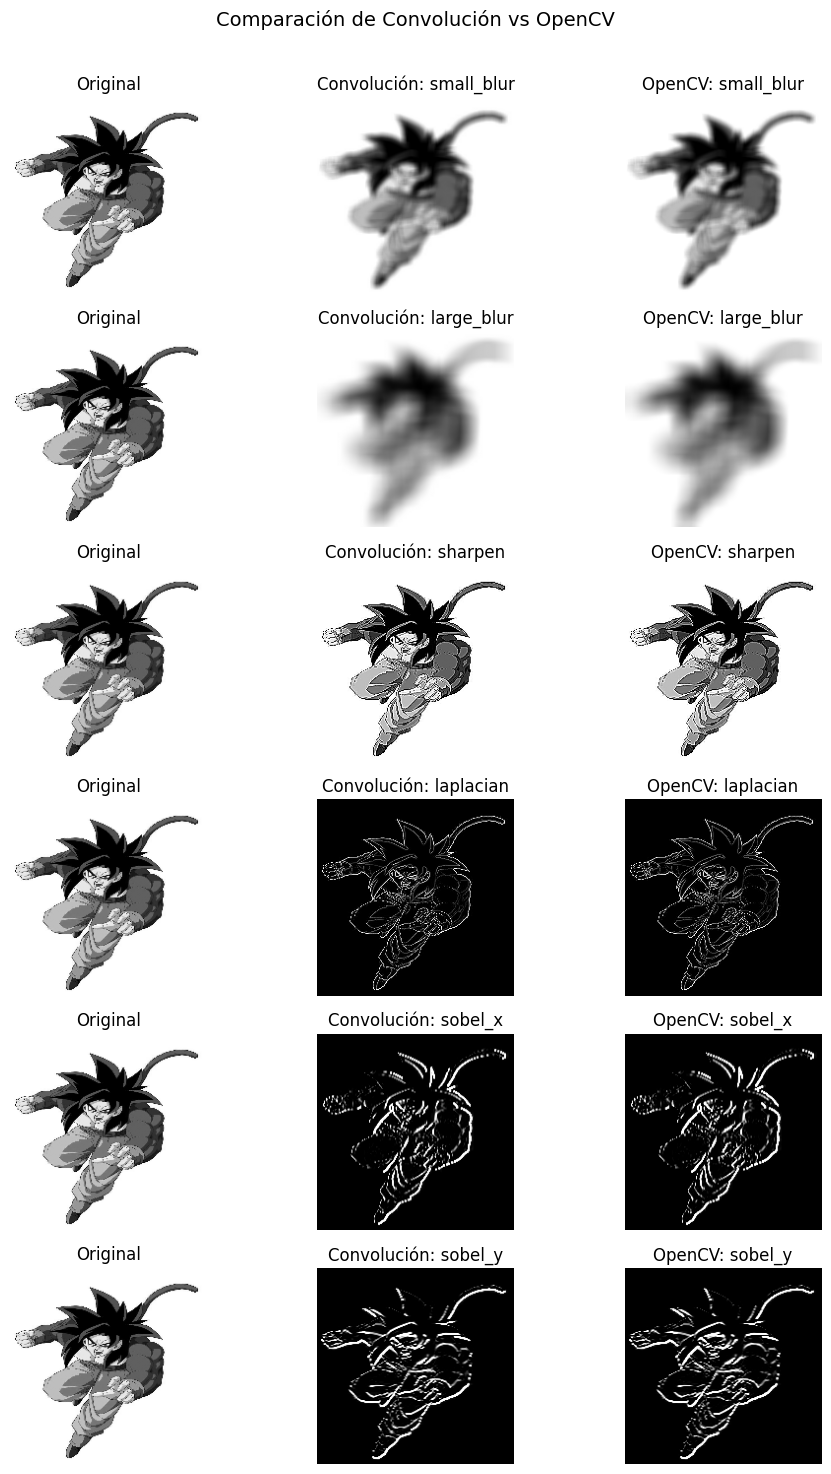

In [6]:
fig, axes = plt.subplots(len(kernelBank), 3, figsize=(10, 15))
fig.suptitle("Comparación de Convolución vs OpenCV", fontsize=14)

for i, (kernelName, kernel) in enumerate(kernelBank.items()):
    convolveOutput = convolve(gray, kernel)
    opencvOutput = cv2.filter2D(gray, -1, kernel)

    axes[i, 0].imshow(gray, cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(convolveOutput, cmap='gray')
    axes[i, 1].set_title(f"Convolución: {kernelName}")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(opencvOutput, cmap='gray')
    axes[i, 2].set_title(f"OpenCV: {kernelName}")
    axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 🌀 **5. Creando un Kernel Gaussiano**

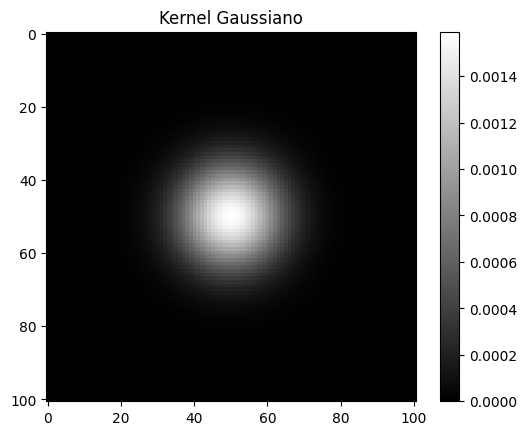

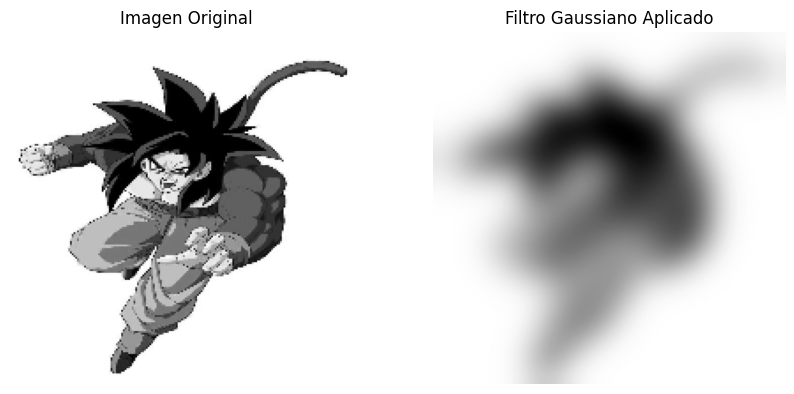

In [7]:
def gaussian_kernel(sample_range, sigma=1):
    """
    Crea un kernel gaussiano muestreado entre [-sample_range, sample_range] con una desviación estándar sigma.
    """
    ax = np.linspace(-sample_range, sample_range, num=sample_range*2+1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx ** 2 + yy ** 2) / (2 * sigma ** 2))
    return kernel / np.sum(kernel)

# Generar kernel gaussiano
kernel = gaussian_kernel(50, sigma=10)
plt.imshow(kernel, cmap='gray')
plt.title("Kernel Gaussiano")
plt.colorbar()
plt.show()

# Aplicar el filtro Gaussiano
opencvOutput = cv2.filter2D(gray, -1, kernel)

# Mostrar resultados
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(gray, cmap='gray')
axes[0].set_title("Imagen Original")
axes[0].axis('off')
axes[1].imshow(opencvOutput, cmap='gray')
axes[1].set_title("Filtro Gaussiano Aplicado")
axes[1].axis('off')
plt.show()

## 🎲 **6. Agregando Ruido a la Imagen**
1️⃣ Ruido Blanco  
2️⃣ Ruido Sal y Pimienta  
3️⃣ Ruido de Disparo (Shot Noise)  

In [8]:
%%capture
url = "https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/2024/Sesiones/Sesion2/Imagenes/Lena.jpg"
name = "Lena.jpg"
!wget -O $name $url

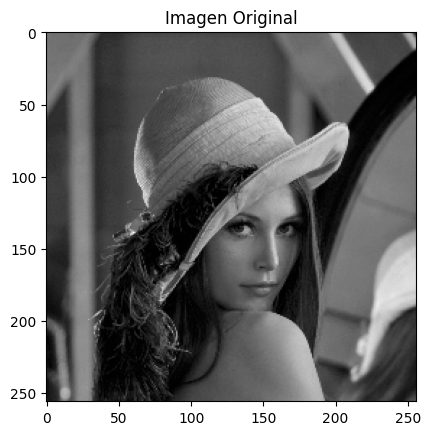

In [9]:
WHITE_LEVEL = 255
SIZE = 256
image = cv2.imread("Lena.jpg", cv2.IMREAD_GRAYSCALE) / WHITE_LEVEL
image = cv2.resize(image, (SIZE, SIZE))

plt.imshow(image, cmap='gray')
plt.title("Imagen Original")
plt.show()

### 📢 **Ruido Blanco**

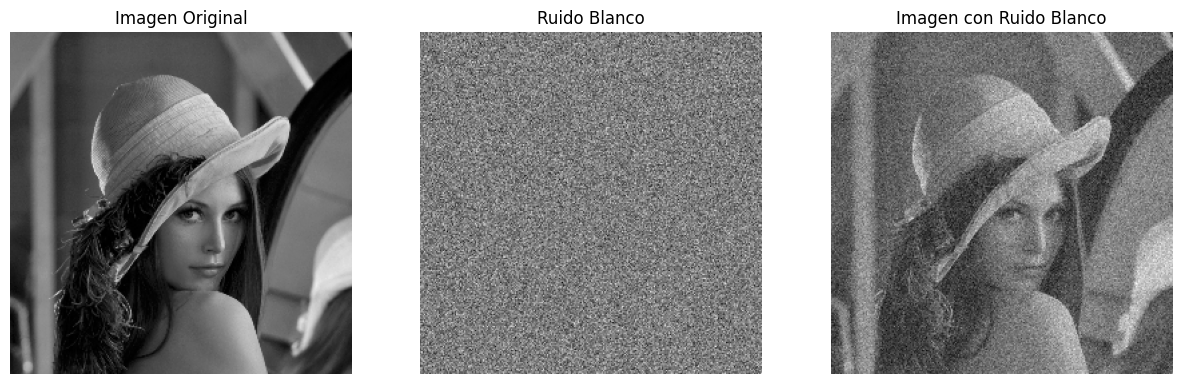

In [10]:
NOISE_STD = 0.1
noise = np.random.normal(scale=NOISE_STD, size=image.shape)
noisy_image = image + noise

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Imagen Original")
axes[0].axis('off')
axes[1].imshow(noise, cmap='gray')
axes[1].set_title("Ruido Blanco")
axes[1].axis('off')
axes[2].imshow(noisy_image, cmap='gray')
axes[2].set_title("Imagen con Ruido Blanco")
axes[2].axis('off')
plt.show()

### 🔍 **Ruido en el Dominio de Frecuencia**

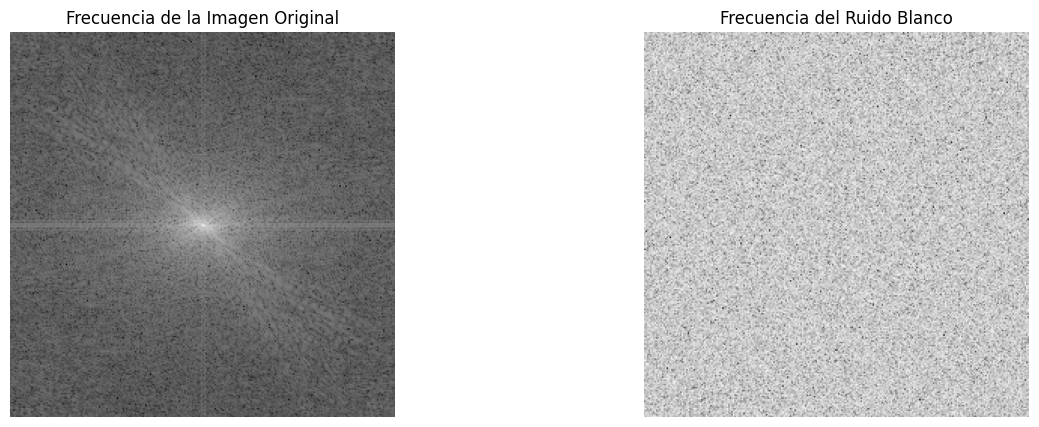

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fourier_lena = fftpack.fftshift(fftpack.fft2(image))
axes[0].imshow(np.log(np.abs(fourier_lena)), cmap='gray')
axes[0].set_title("Frecuencia de la Imagen Original")
axes[0].axis('off')

fourier_noise = fftpack.fftshift(fftpack.fft2(noise))
axes[1].imshow(np.log(np.abs(fourier_noise)), cmap='gray')
axes[1].set_title("Frecuencia del Ruido Blanco")
axes[1].axis('off')

plt.show()

### 🌑 **Ruido de Sal y Pimienta** y **Ruido de Disparo (Shot Noise)**

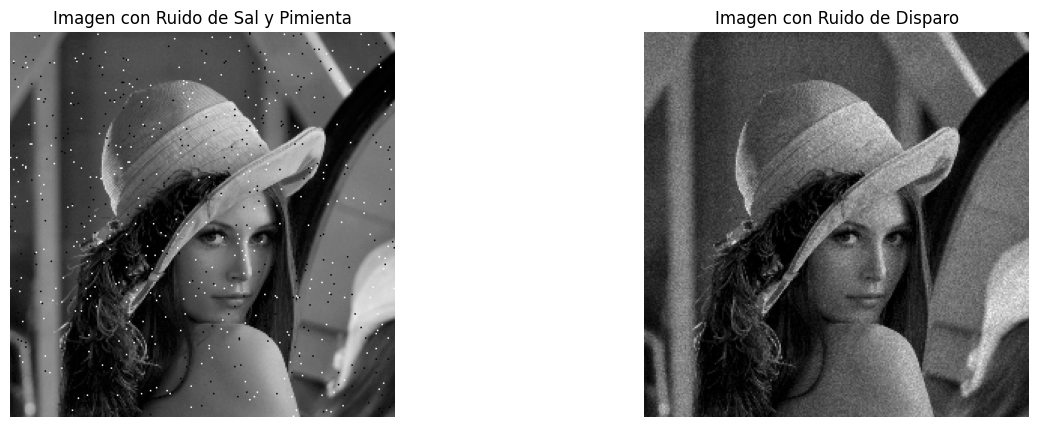

In [12]:
# Salt and Pepper
AMOUNT = 0.01
SALT_VS_PEPPER = 0.5
noisy_image_sp = image.copy()
num_faulty_pixels = np.ceil(AMOUNT * image.size).astype(int)
indices = np.random.randint(0, high=SIZE, size=(2, num_faulty_pixels))
values = np.random.binomial(1, SALT_VS_PEPPER, size=num_faulty_pixels)
noisy_image_sp[tuple(np.split(indices, 2))] = values

# shot noise
NUM_BINS = 256
lam = image * WHITE_LEVEL
noisy_image_shot = np.random.poisson(lam=lam) / WHITE_LEVEL
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(noisy_image_sp, cmap='gray')
axes[0].set_title("Imagen con Ruido de Sal y Pimienta")
axes[0].axis('off')

axes[1].imshow(noisy_image_shot, cmap='gray')
axes[1].set_title("Imagen con Ruido de Disparo")
axes[1].axis('off')

plt.show()

## 🎭 **7. Desenfoque (Blur)**
1️⃣ **Desenfoque Focal**  
2️⃣ **Desenfoque por Movimiento**

### 🎯 **Desenfoque Focal**

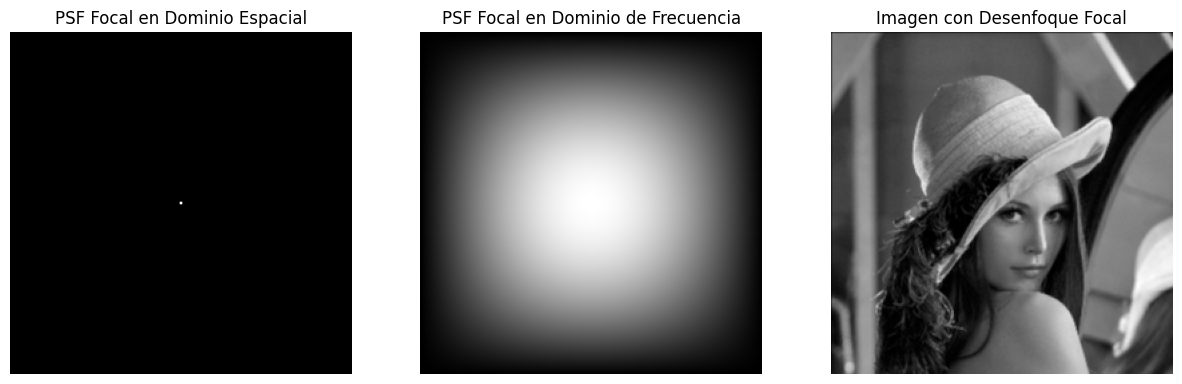

In [13]:
FOCAL_STD = 0.1
def gaussian_kernel(size, std=1):
    edge = size // 2
    ax = np.linspace(-edge, edge, num=size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx ** 2 + yy ** 2) / (2 * std **2))
    return kernel / kernel.sum()

psf = gaussian_kernel(SIZE , std=FOCAL_STD)
psf_dft = fftpack.fftshift(fftpack.fft2(psf))
blurred_image = signal.convolve(image, psf, mode='same')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(psf, cmap='gray')
axes[0].set_title("PSF Focal en Dominio Espacial")
axes[0].axis('off')

axes[1].imshow(np.abs(psf_dft), cmap='gray')
axes[1].set_title("PSF Focal en Dominio de Frecuencia")
axes[1].axis('off')

axes[2].imshow(blurred_image, cmap='gray')
axes[2].set_title("Imagen con Desenfoque Focal")
axes[2].axis('off')

plt.show()


## 🚀 **8. Desenfoque por Movimiento (Motion Blur)**

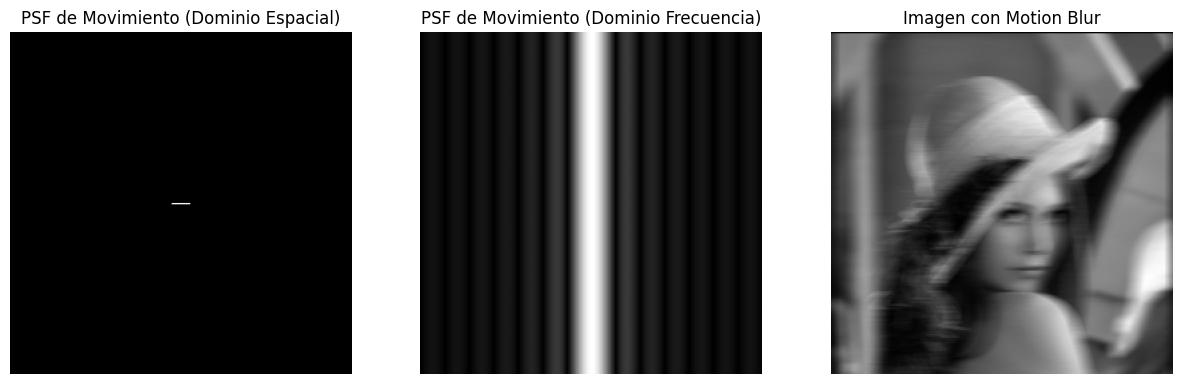

In [14]:
LENGTH = 15

def horizontal_motion_blur(size, length):
    """
    Genera un kernel de desenfoque por movimiento horizontal.
    """
    center = size // 2
    shift = length // 2
    kernel = np.zeros((size, size))
    kernel[center:center + 1, center - shift:center + shift] = 1
    return kernel / kernel.sum()

psf = horizontal_motion_blur(SIZE, LENGTH)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(psf, cmap='gray')
axes[0].set_title("PSF de Movimiento (Dominio Espacial)")
axes[0].axis('off')

psf_dft = fftpack.fftshift(fftpack.fft2(psf))
axes[1].imshow(np.abs(psf_dft), cmap='gray')
axes[1].set_title("PSF de Movimiento (Dominio Frecuencia)")
axes[1].axis('off')

blurred_image = signal.convolve(image, psf, mode='same')
axes[2].imshow(blurred_image, cmap='gray')
axes[2].set_title("Imagen con Motion Blur")
axes[2].axis('off')

plt.show()

## 🔄 **9. Filtrado Inverso**

📌 **Recuperación de imágenes borrosas usando filtrado inverso.**

Si tenemos la ecuación:
$y = h \circledast f $

Donde $f$ es la imagen original y $y$ es la versión desenfocada con una PSF $h$, podemos estimar $f$ usando:

$\hat{F} = Y/H$

En el dominio de la frecuencia.

🚀 **¡Experimenta!** Cambia los filtros o agrega nuevos kernels para ver su efecto en la imagen.

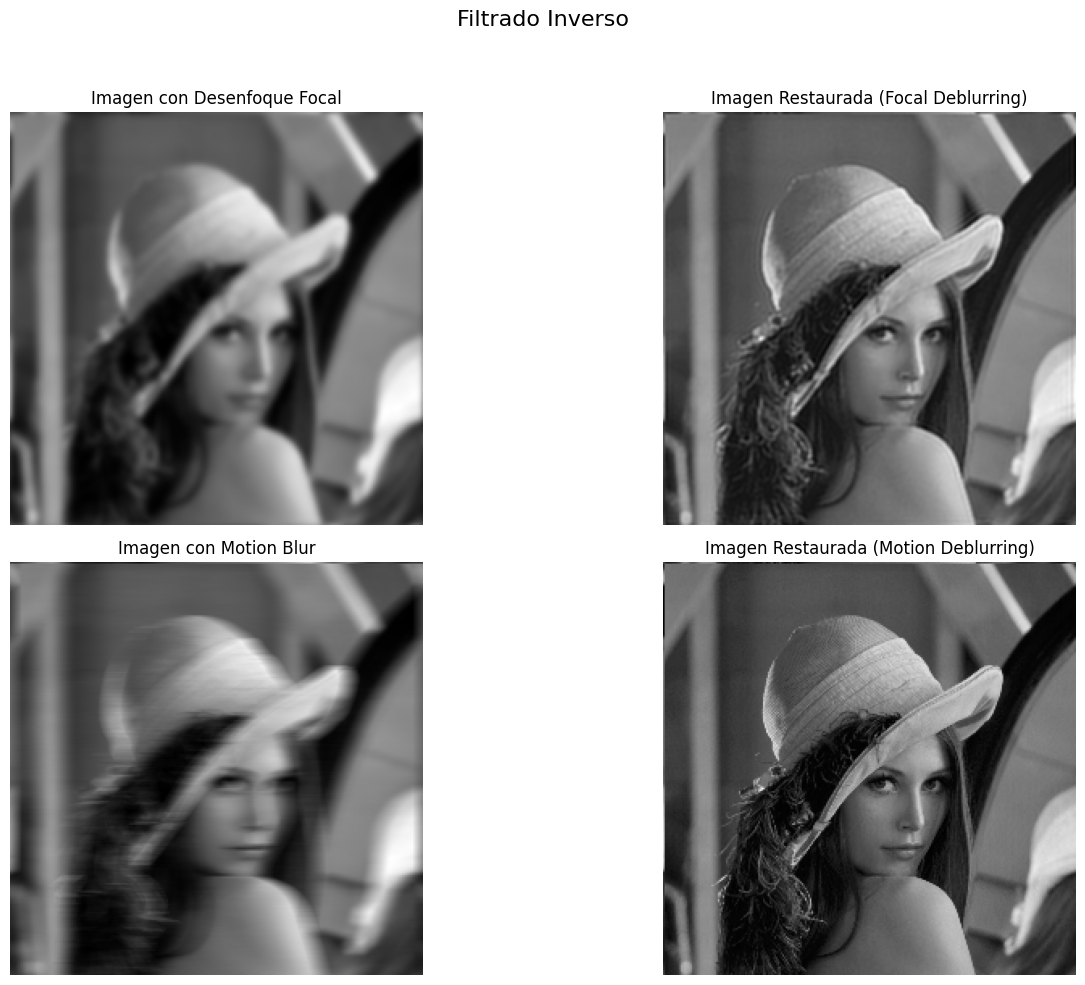

In [15]:
EPSILON = 1e-3
FOCAL_STD = 3
LENGTH = 15

def inverse_filter(image, psf):
    """
    Recupera la imagen original aplicando filtrado inverso en el dominio de la frecuencia.
    """
    image_dft = fftpack.fft2(image)
    psf_dft = fftpack.fft2(fftpack.ifftshift(psf))
    recovered_dft = image_dft / (psf_dft + EPSILON)
    return np.real(fftpack.ifft2(recovered_dft))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Filtrado Inverso", fontsize=16)

# Desenfoque Focal
focal_blur_psf = gaussian_kernel(SIZE, std=FOCAL_STD)
focal_blurred_image = signal.convolve2d(image, focal_blur_psf, mode='same', boundary='wrap')
axes[0, 0].imshow(focal_blurred_image, cmap='gray')
axes[0, 0].set_title("Imagen con Desenfoque Focal")
axes[0, 0].axis('off')

# Restauración Focal
focal_deblurred_image = inverse_filter(focal_blurred_image, focal_blur_psf)
axes[0, 1].imshow(focal_deblurred_image, cmap='gray')
axes[0, 1].set_title("Imagen Restaurada (Focal Deblurring)")
axes[0, 1].axis('off')

# Desenfoque por Movimiento
motion_blur_psf = horizontal_motion_blur(SIZE, LENGTH)
motion_blurred_image = signal.convolve2d(image, motion_blur_psf, mode='same', boundary='wrap')
axes[1, 0].imshow(motion_blurred_image, cmap='gray')
axes[1, 0].set_title("Imagen con Motion Blur")
axes[1, 0].axis('off')

# Restauración por Movimiento
motion_deblurred_image = inverse_filter(motion_blurred_image, motion_blur_psf)
axes[1, 1].imshow(motion_deblurred_image, cmap='gray')
axes[1, 1].set_title("Imagen Restaurada (Motion Deblurring)")
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


📌 **Observaciones:**

- El filtrado inverso puede recuperar detalles de la imagen desenfocada, pero introduce artefactos debido a la amplificación del ruido en altas frecuencias.
- La restauración del desenfoque por movimiento es más efectiva, ya que conserva más información en el dominio de la frecuencia.

🔎 **¡Experimenta!** Cambia los parámetros de desenfoque y observa cómo afecta la restauración de la imagen. 🚀